<a href="https://colab.research.google.com/github/uol-mediaprocessing-202021/medienverarbeitung-g-what-should-i-glue/blob/rcnn/rcnn_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip list

In [ ]:
!pip uninstall keras tensorflow

In [ ]:
!pip install keras==2.0.8 tensorflow==1.15.0

In [ ]:
#!git clone https://github.com/matterport/Mask_RCNN.git

In [ ]:
!pwd 

/content


In [4]:
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [5]:
import os
import sys
import json
import skimage.draw
import numpy as np

ROOT_DIR = os.path.abspath("Mask_RCNN/")

sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import config
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

COCO_WEIGHTS_PATH = "Mask_RCNN/mask_rcnn_coco.h5"
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)

GLUE_WEIGHTS_PATH = "Mask_RCNN/logs/glue20201220T1435/mask_rcnn_glue_0024.h5"

GLUE_DIR = os.path.join(ROOT_DIR, "img")

Using TensorFlow backend.


In [ ]:
class GlueConfig(config.Config):
  NAME = "glue"
  IMAGES_PER_GPU = 2
  NUM_CLASSES = 1 + 2
  STEPS_PER_EPOCH = 20
  DETECTION_MIN_CONFIDENCE = 0.9
  VALIDATION_STEPS = 25
  # Number of color channels per image. RGB = 3, grayscale = 1, RGB-D = 4
    # Changing this requires other changes in the code. See the WIKI for more
    # details: https://github.com/matterport/Mask_RCNN/wiki
    #IMAGE_CHANNEL_COUNT = 3
    # TODO: You could adapt this later for canny/thresholded images

In [6]:
class GlueDataset(utils.Dataset):

  def load_glue(self, dataset_dir, subset):
    print("Loading GLue, my own load_glue")
    self.add_class('glue', 1, 'test_piece')
    self.add_class('glue', 2, 'carrier')

    assert subset in ["pos", "val"]
    dataset_dir = os.path.join(dataset_dir, subset)
    region_data = "via_project_" + subset + ".json"

    annotations = json.load(open(os.path.join(dataset_dir, region_data)))
    #print(annotations)
    annotations = list(annotations.values())
    #print(annotations)

    # skip unannotated images, i shouldnt need this, cause all my images should be labeled
    annotations = [a for a in annotations if a['regions']]
    #print(annotations)

    for a in annotations: 

      polygons = [r['shape_attributes'] for r in a['regions']] 
      category = [r['region_attributes'] for r in a['regions']] 
      #print(polygons)
      #print(category)

      # the images should all be the same size (same camera...) (4000|3000)
      # with that you could skip this part to make it faster
      image_path = os.path.join(dataset_dir, a['filename'])
      #image = skimage.io.imread(image_path) #very slow: height:  3000 width:  4000
      # height, width = image.shape[:2]
      # TODO: make this widht, height pretty, this sucks, you dont need it like this
      height = 3000
      width = 4000
      #print("height: ", height, "width: ", width)
      #print("add Image")
      self.add_image("glue", image_id=a['filename'], path=image_path, 
                     width=width, height=height,
                     polygons=polygons, category=category)
      # annotations saved per image,

  def load_mask(self, image_id):
    # the following 3 lines are not necessary for me, TODO: maybe delete these later
    image_info = self.image_info[image_id]
    if image_info["source"] != "glue":
        return super(self.__class__, self).load_mask(image_id)
    

    info = self.image_info[image_id]
    mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                    dtype=np.uint8)
    class_ids = []
    for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x']) # TODO: make this faster, look for another way to get polygons
            mask[rr, cc, i] = 1
    for c in info["category"]:
      #class_ids.append(c["category"])
      class_ids.append(self.class_names.index(c["category"])) 
    #print(class_ids)
    
    return mask.astype(np.bool), np.array(class_ids, dtype=np.int32) #maybe np.asarray


  def image_reference(self, image_id):
    info = self.image_info[image_id]
    print(info["source"])
    if info["source"] == "glue":
      print(info["path"])
      return info["path"]
    else:
      super(self.__class__, self).image_reference(image_id)

In [ ]:
config = GlueConfig()
config.display()

In [ ]:
###################################################
# confirm dataset stuff
###################################################
dataset = GlueDataset()
dataset.load_glue(GLUE_DIR, "pos")
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Loading GLue, my own load_glue
Image Count: 53
Class Count: 3
  0. BG                                                
  1. test_piece                                        
  2. carrier                                           


In [ ]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [ ]:
import random 

#image_id = random.choice(dataset.image_ids)
image_id = 9
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [ ]:
#image_id = np.random.choice(dataset.image_ids, 1)[0]
image_id = 9
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [ ]:
#image_id = np.random.choice(dataset.image_ids, 1)[0]
image_id = 9
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [ ]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [ ]:
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])


In [ ]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# balloon_ inspect_balloon_data

Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts.

    Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
    Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row.
    For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

Anchor Stride: In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (2562563). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example.

In this implementation we use an anchor stride of 2, which is different from the paper.


In [ ]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))


Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


In [ ]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

In [ ]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

In [ ]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

In [ ]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

In [ ]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

In [ ]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    visualize.display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [ ]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

In [7]:
### dataset training here
dataset_train = GlueDataset()
dataset_train.load_glue(GLUE_DIR, "pos")
dataset_train.prepare()

dataset_val = GlueDataset()
dataset_val.load_glue(GLUE_DIR, "val")
dataset_val.prepare()

Loading GLue, my own load_glue
Loading GLue, my own load_glue


In [ ]:
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=MODEL_DIR)

In [ ]:
WEIGHTS_PATH = GLUE_WEIGHTS_PATH
print("Loading weights ", WEIGHTS_PATH)

Loading weights  Mask_RCNN/logs/glue20201220T1435/mask_rcnn_glue_0014.h5


In [ ]:
 model.load_weights(WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=25,
            layers='heads')

Training network heads

Starting at epoch 20. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Colab Notebooks/Mask_RCNN/logs/glue20201220T1435/mask_rcnn_glue_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcn

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessi

Epoch 21/25
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[1]
[1]
[1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[1, 1, 1, 1, 2]
 3/20 [===>..........................] - ETA: 180s - loss: 0.4392 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.1009 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.1157 - mrcnn_mask_loss: 0.1234[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
 8/20 [===========>..................] - ETA: 56s - loss: 0.5642 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.1894[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
10/20 [==============>...............] - ETA: 41s - loss: 0.5330 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.1593 - mrcnn_mask_loss: 0.1830[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[1, 1, 1, 1]
12/20 [=================>............] - ETA: 30s - loss: 0.5309 - rpn_class_loss: 0.0112 - rpn

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[1, 1, 1, 1]
[2, 1, 1, 1, 1]
[1]
[2, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1]
[2, 1]
[2, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1]
[1]
[2, 1, 1, 1, 1]
[1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1, 1, 1, 1]
[2, 1]
[2, 1, 1, 

In [29]:
!pwd

/content/drive/MyDrive/Colab Notebooks


In [32]:
%cd ../

/content/drive/My Drive/Colab Notebooks


In [ ]:
dataset_train = GlueDataset()
dataset_train.load_glue(GLUE_DIR, "pos")
dataset_train.prepare()

dataset_val = GlueDataset()
dataset_val.load_glue(GLUE_DIR, "val")
dataset_val.prepare()

In [ ]:
# Override the training configurations with a few
# changes for inferencing.
from mrcnn import config

class InferenceConfig(config.Config):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NAME = "glueInference"
    NUM_CLASSES = 1 + 2
    #STEPS_PER_EPOCH = 20
    #DETECTION_MIN_CONFIDENCE = 0.9
    #VALIDATION_STEPS = 25

config = InferenceConfig()
config.display()

In [ ]:
import tensorflow as tf

DEVICE = "/gpu:0" # apperently not needed, only to 'downgrade' to cpu, if gpu mode of colab is on
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", config=config,
                              model_dir=MODEL_DIR)

In [21]:
import numpy as np
# TODO: Create a loop, reload every model 
# another loop in that loop that makes predictions for every img in validation
# store those in a list
# plot the list accuracy

def train_val_accuracy(cnt_epochs=25):
  train_accuracy = []
  val_accuracy = []
  for i in range(cnt_epochs): 
    if i < 10: 
      WEIGHTS_PATH = "Mask_RCNN/logs/glue20201220T1435/mask_rcnn_glue_000{}.h5".format(i)
      print(WEIGHTS_PATH)
    else: 
      WEIGHTS_PATH = "Mask_RCNN/logs/glue20201220T1435/mask_rcnn_glue_00{}.h5".format(i)
      print(WEIGHTS_PATH)
    model.load_weights(WEIGHTS_PATH, by_name=True)
    print("Loaded weights: {}".format(i))
    
    APs_val = []
    for i in dataset_val.image_ids:
      image, gt_image_meta, gt_class_ids, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, config, i)
      result = model.detect([image], verbose=0)
      r = result[0]
      AP = utils.compute_ap_range(gt_bbox, gt_class_ids, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
      AP = np.mean(AP)
      APs_val.append(AP)
    mAP_val = np.mean(APs_val)
    print("mAP_val ", mAP_val)
    val_accuracy.append(mAP_val)
    
    APs_train = []
    for i in dataset_train.image_ids:
      image, gt_image_meta, gt_class_ids, gt_bbox, gt_mask = modellib.load_image_gt(dataset_train, config, i)
      result = model.detect([image], verbose=0)
      r = result[0]
      AP = utils.compute_ap_range(gt_bbox, gt_class_ids, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
      AP = np.mean(AP)
      APs_train.append(AP)
    mAP_train = np.mean(APs_train)
    print("mAP_train ", mAP_train)
    train_accuracy.append(mAP_val)
  return train_accuracy, val_accuracy

In [23]:
import matplotlib.pyplot as plt
cnt_epochs = 25
train_acc, val_acc = train_val_accuracy(cnt_epochs)


AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 0.640
AP @0.80:	 0.640
AP @0.85:	 0.640
AP @0.90:	 0.640
AP @0.95:	 0.000
AP @0.50-0.95:	 0.756
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 0.680
AP @0.70:	 0.680
AP @0.75:	 0.680
AP @0.80:	 0.680
AP @0.85:	 0.500
AP @0.90:	 0.500
AP @0.95:	 0.000
AP @0.50-0.95:	 0.672
AP @0.50:	 0.967
AP @0.55:	 0.967
AP @0.60:	 0.967
AP @0.65:	 0.967
AP @0.70:	 0.733
AP @0.75:	 0.333
AP @0.80:	 0.333
AP @0.85:	 0.333
AP @0.90:	 0.200
AP @0.95:	 0.000
AP @0.50-0.95:	 0.580
AP @0.50:	 0.900
AP @0.55:	 0.900
AP @0.60:	 0.900
AP @0.65:	 0.900
AP @0.70:	 0.900
AP @0.75:	 0.900
AP @0.80:	 0.600
AP @0.85:	 0.400
AP @0.90:	 0.200
AP @0.95:	 0.000
AP @0.50-0.95:	 0.660
AP @0.50:	 0.760
AP @0.55:	 0.760
AP @0.60:	 0.760
AP @0.65:	 0.760
AP @0.70:	 0.760
AP @0.75:	 0.760
AP @0.80:	 0.760
AP @0.85:	 0.760
AP @0.90:	 0.200
AP @0.95:	 0.000
AP @0.50-0.95:	 0.628
AP @0.50:	 0.500
AP @0.55:	 0.500
AP @0.

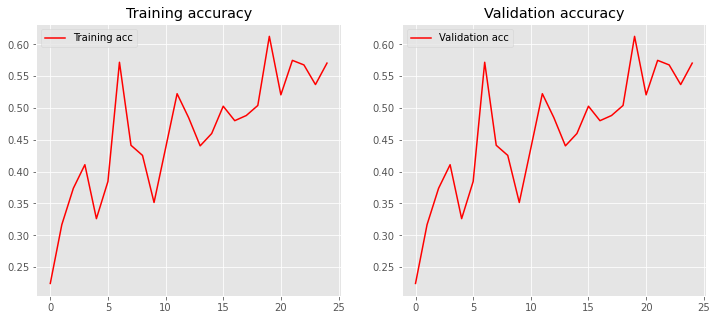

In [24]:
x = range(0, cnt_epochs)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(x, train_acc, 'r', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.subplot(122)
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Validation accuracy')
plt.legend()

In [ ]:
import tensorflow as tf
%load_ext tensorboard
#%reload_ext tensorboard

In [ ]:
%tensorboard --logdir Mask_RCNN/logs/glue20201220T1435

In [ ]:
# Precision Recall (coco: inspect_model)

# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

In [ ]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   30.43991  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   33.91841  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   81.98112  float32
rpn_bbox                 shape: (1, 261888, 4)        min:   -9.75782  max:   56.61624  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


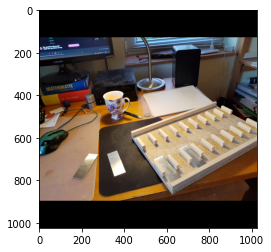

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

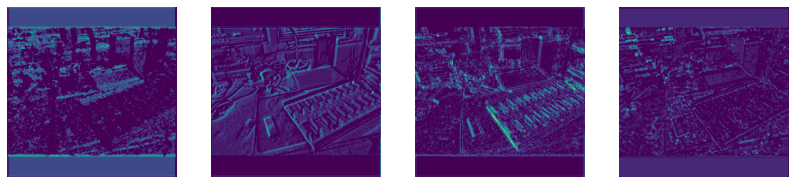

In [ ]:
# Backbone feature map
visualize.display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

In [ ]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

In [ ]:


# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()



- try out more than two images per gpu: Done, sucks, crashes
- check wether this thing with the epochs works correctly when its finished: Done, continue from epoch xy -> in model.train(epoch=xy+z)
- maybe add two of the original images to pos, the other two to val
- add plots for accuracy and loss (look how you did that in bigD or the kangaruu website
# Man why not sooner, didnt know that you had to activate GPU in Runtime setting AHHHHHHH

In [ ]:
##################################################################################################
##################################################################################################
#canny model 
##################################################################################################
##################################################################################################

config = GlueConfig()
config.display()

In [ ]:
### dataset training here
dataset_train = GlueDataset()
dataset_train.load_glue(GLUE_DIR, "pos")
dataset_train.prepare()

dataset_val = GlueDataset()
dataset_val.load_glue(GLUE_DIR, "val")
dataset_val.prepare()

In [ ]:
#import mrcnn.model_canny as modellib_canny
import os
import sys
ROOT_DIR = os.path.abspath("Mask_RCNN/")

sys.path.append(ROOT_DIR)
import mrcnn.model_canny as modellib_canny

In [ ]:
model = modellib_canny.MaskRCNN(mode="training", config=config,
                                  model_dir=MODEL_DIR)

In [ ]:
 print("Loading weights ", WEIGHTS_PATH)
 model.load_weights(WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=5,
            layers='heads')

In [ ]:
###############################
# Review weights stats
##############################

# Show stats of all trainable weights    
visualize.display_weight_stats(model)



In [ ]:
# Override the training configurations with a few
# changes for inferencing.
from mrcnn import config

class InferenceConfig(config.Config):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NAME = "glueInference"
    NUM_CLASSES = 1 + 2
    #STEPS_PER_EPOCH = 20
    #DETECTION_MIN_CONFIDENCE = 0.9
    #VALIDATION_STEPS = 25

config = InferenceConfig()
config.display()

In [ ]:
import matplotlib.pyplot as plt

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
# Load validation dataset
dataset = GlueDataset()
dataset.load_glue(GLUE_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))  

In [ ]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [ ]:
import tensorflow as tf

DEVICE = "/cpu:0"
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", config=config,
                              model_dir=MODEL_DIR)

In [ ]:
!pwd

In [ ]:
#weights_path = model.find_last()
weights_path = "Mask_RCNN/logs/glue20201220T1435/mask_rcnn_glue_0009.h5"
#weights_path = "Mask_RCNN/mask_rcnn_coco.h5"
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)


In [ ]:
#image_id = random.choice(dataset.image_ids)
image_id = 4
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [ ]:
# Compute mAP @ IoU=50 on Batch of Images (coco: inspect_model)

# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

In [ ]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -1.81697  max:    1.25000  float64
positive_anchors         shape: (15, 4)               min:  144.00000  max: 1024.00000  float64
negative_anchors         shape: (241, 4)              min: -181.01934  max: 1152.00000  float64
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (15, 4)               min:  158.00000  max: 1023.00000  float32


In [ ]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

In [ ]:
# 1.b RPN Predictions
#    Here we run the RPN graph and display its predictions.


# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35390  max:    1.22878  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.42581  max:    1.20448  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 4803.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


In [ ]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

In [ ]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

In [ ]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

In [ ]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [ ]:
# coco: inspect_model
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.
2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 3)          min:    0.00000  max:    0.99988  float32
deltas                   shape: (1, 1000, 3, 4)       min:   -4.48175  max:    4.69469  float32
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00023  max:    0.99988  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32


In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

2.c Step by Step Detection

Here we dive deeper into the process of processing the detections

In [ ]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
88 Positive ROIs
[('BG', 912), ('carrier', 22), ('test_piece', 66)]


In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 88 detections:
[  0   1   2   4   7   9  10  11  12  13  15  17  18  22  24  25  28  29
  30  31  43  46  60  61  66  73  77  91  94  96 103 106 107 109 115 116
 120 121 122 123 125 126 134 170 177 200 205 234 273 282 288 297 309 316
 324 329 343 344 368 369 394 419 448 450 483 509 529 542 544 552 579 614
 651 673 678 712 742 812 830 834 851 898 916 927 953 961 962 993]


In [ ]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 19:
[  0   2   4  11  18  30  31  96 122 273 324 394 448 529 542 544 579 678
 742]


In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

test_piece            : [  2  11  30  96 122 273 324 394 448 529 542 544 579] -> [448 579  96  30]
carrier               : [  0   4  18  31 678 742] -> [31]

Kept after per-class NMS: 5
[ 30  31  96 448 579]


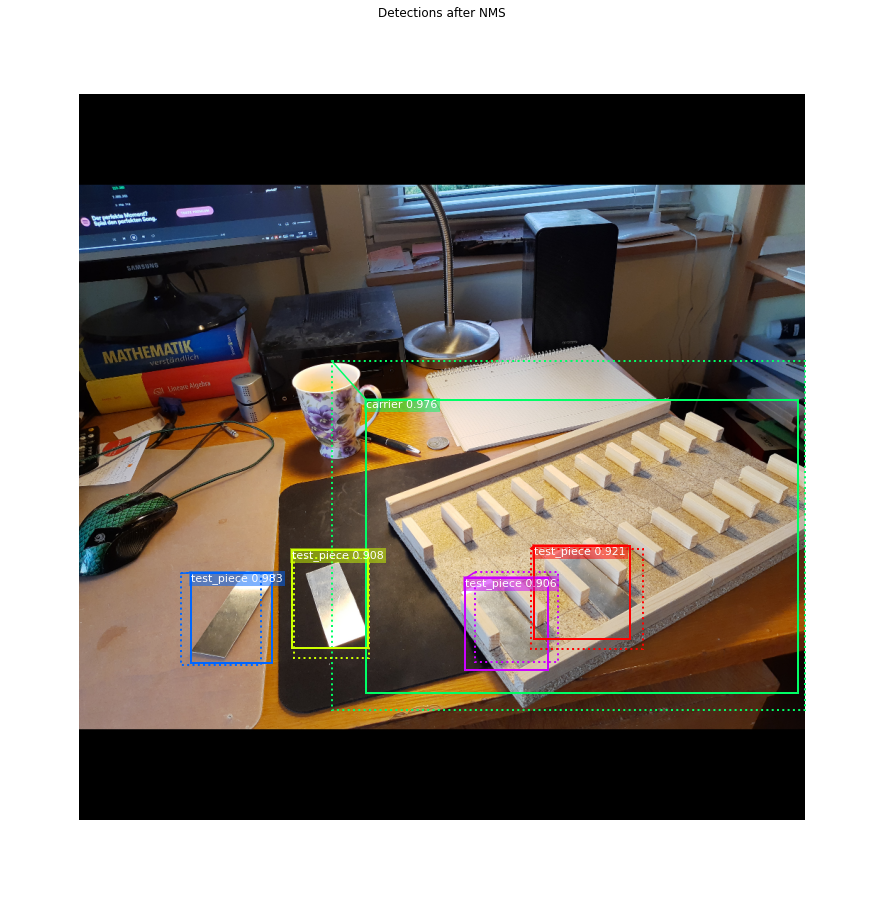

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

In [ ]:
visualize.display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00023  max:    0.99988  float32
5 detections: ['test_piece' 'carrier' 'test_piece' 'test_piece' 'test_piece']


In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (5, 28, 28)           min:    0.00023  max:    0.99975  float32
det_masks                shape: (5, 1024, 1024)       min:    0.00000  max:    1.00000  bool


In [ ]:
visualize.display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

In [ ]:
visualize.display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   30.43991  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   33.91841  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   81.98112  float32
rpn_bbox                 shape: (1, 261888, 4)        min:   -9.75782  max:   56.61624  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


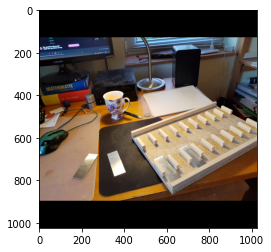

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

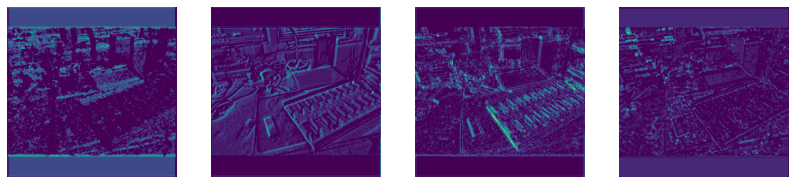

In [ ]:
# Backbone feature map
visualize.display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

In [ ]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

In [ ]:


# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()



In [ ]:
###################################################################
###################################################################
#
# Ab hier test an original bildern und video 
#
###################################################################
###################################################################


In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# Override the training configurations with a few
# changes for inferencing.
from mrcnn import config

class InferenceConfig(config.Config):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NAME = "glueInference"
    NUM_CLASSES = 1 + 2
    #STEPS_PER_EPOCH = 20
    #DETECTION_MIN_CONFIDENCE = 0.9
    #VALIDATION_STEPS = 25

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
import matplotlib.pyplot as plt

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks


In [ ]:
import tensorflow as tf

DEVICE = "/gpu:0" # apperently not needed, only to 'downgrade' to cpu, if gpu mode of colab is on
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", config=config,
                              model_dir=MODEL_DIR)


#weights_path = model.find_last()
weights_path = "Mask_RCNN/logs/glue20201220T1435/mask_rcnn_glue_0014.h5"
#weights_path = "Mask_RCNN/mask_rcnn_coco.h5"
print(weights_path)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Mask_RCNN/logs/glue20201220T1435/mask_rcnn_glue_0014.h5


In [ ]:
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  Mask_RCNN/logs/glue20201220T1435/mask_rcnn_glue_0014.h5





Re-starting from epoch 14


In [ ]:
#image = skimage.io.imread("Mask_RCNN/img/val/Pos_11.jpg")
image = skimage.io.imread("Mask_RCNN/img/val_old/Test_Pieces_4.jpg")
image1 = skimage.io.imread("Mask_RCNN/img/IMG_20201221_175103262.jpg")
image2 = skimage.io.imread("Mask_RCNN/img/IMG_20201221_175113762.jpg")
image3 = skimage.io.imread("Mask_RCNN/img/IMG_20201221_175123504.jpg")
image4 = skimage.io.imread("Mask_RCNN/img/IMG_20201221_175128251.jpg")

In [ ]:
test_data = GlueDataset()
test_data.load_glue(GLUE_DIR, "pos")
test_data.prepare()

Loading GLue, my own load_glue


[2, 1, 1, 1, 1]


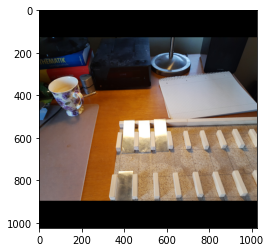

In [ ]:
img,_,_,_,_ = modellib.load_image_gt(test_data, config, 5)
plt.imshow(img)
#plt.show(img)

Processing 1 images
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


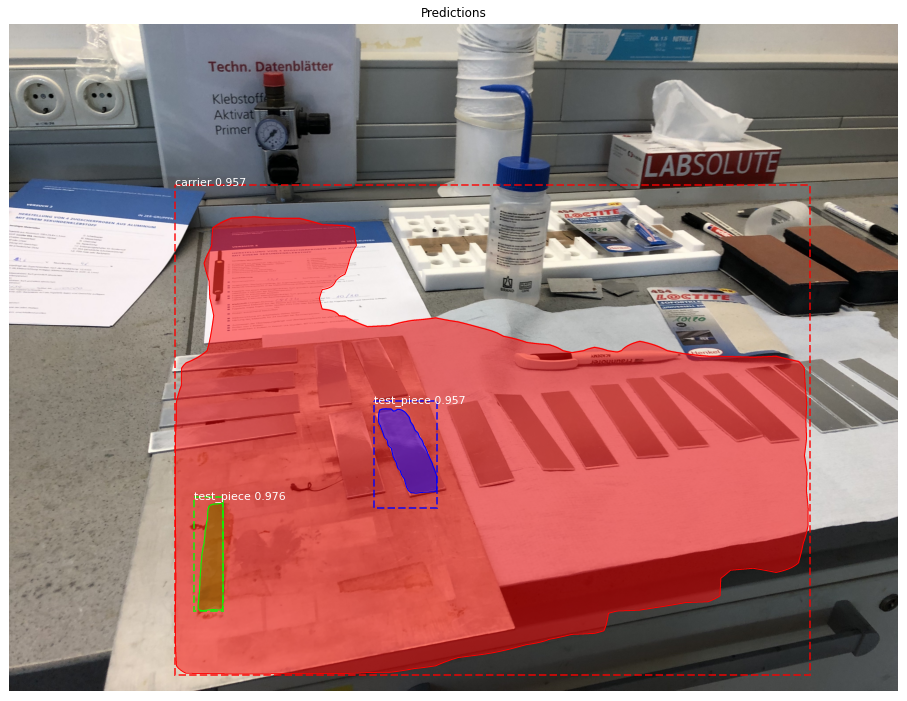

In [ ]:
image = skimage.io.imread("Mask_RCNN/img/val_old/Test_Pieces_4.jpg")
#image1 = skimage.io.imread("Mask_RCNN/img/IMG_20201221_175113762.jpg")
results = model.detect([image], verbose=1)

ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

In [ ]:
#################################
#Video

In [ ]:
# centroid tracking buh ya
# this is called in display_bboxes_masks after the check in that function, so you can skip the validation part
# there should have went something terribly wrong if that doesnt work, or it is called by another function 

# this computes and displays centroids

# list of all bounding boxes per frame 
# container for all centroids
# 
# compute distance between new and old centroids
#   => update list of centroids 
# only display centroids + frames if detection was not that new 
# give each centroid specific id
# add id to bboxes, display in the image (do that later, no need for presentation, its enough if it works)
#
# check for ten subequent frames 
import math

# TODO: add a value for max distance that a point cant jump far away, to make id switching harder
# some values to configure
start_value = 25  
remove_value = 0
display_thesh_value = 50
maxDistance = 300

# todo: reset / decrease nextID, that you dont get ids of 1000000 for a long video
# todo: Maybe add a check that pieces and carriers are computed seperatly
class CentroidTracker: # centroidtracker class, stores datastructure (list of dicts, maybe change that), and stores counter for ids
  def __init__(self):
    self.nextID = 0
    self.centroids = []


  def addCentroid(self, cen): # this adds a new centroid / object (register)
    self.centroids.append(cen)
    self.nextID += 1

  def insertCentroid(self, cen): # method to 'update'/'replace' an entry
    for nr, c in enumerate(self.centroids):
      if c['id'] == cen['id']:
        self.centroids[nr] = cen
        break

  # TODO: check if it has better results if you decrease the age by 5 instead of one if not updated
  def noUpdate(self): # This checks if an object was updated, removes if no updated for to long 
    for cen in self.centroids: 
      if cen['updated'] == False:
        cen['age'] -= 5
      cen['updated'] = False
    self.removeCentroid()

  def removeCentroid(self): # removes centroid from list, TODO: maybe place this inside noUpdate => should be faster, iterate thru only once
    for cen in self.centroids: 
      if cen['age'] <= remove_value:
        self.centroids.remove(cen) 
      
#  def removeCentroid(self, id):
 #   for c in self.centroids:
  #    if c['id'] == id:
   #     self.centroids.remove(c)

  def centroid_xy_of_bbox(self, box): # returns centroid coordinates as integers
    y1, x1, y2, x2 = box
    xx = int((x1 + x2) / 2)
    yy = int((y1 + y2) / 2)
    return xx,yy

  def distance(self, box): # computes the distance between a single centroid and closest predecessor
    xx,yy = self.centroid_xy_of_bbox(box)
    tmp = None
    tmp_closest = None
    tmp_age = None
    tmp_updated = None
    for c in self.centroids:
      d = math.sqrt((xx - c['x'])**2 + (yy - c['y'])**2)
      if tmp == None or tmp > d:
        tmp = d
        tmp_closest = c['id']
        tmp_age = c['age'] + 1
        tmp_updated = c['updated']
    return tmp, tmp_closest, xx, yy, tmp_age, tmp_updated

  # TODO: tmp_updated from dist is wrong, always set to false after executeion of noUpdate => every check should return false after that 
  # maybe it is not wrong at all, since it check wether an old centroid was matche already with a new bbox in that same iteration 
  def updateCentroids(self, bboxes): # updates the datastructure, the important part # TODO: improve this one 
    M = len(self.centroids)
    N = len(bboxes)
    if M == 0:
      for nr, b in enumerate(bboxes): 
        xx,yy = self.centroid_xy_of_bbox(b)  
        cent = {'id': self.nextID, 'x': xx, 'y': yy, 'age': start_value, 'updated': True, 'cur_bbox_id': nr}
        self.addCentroid(cent)
      self.noUpdate()
    else:
    # TODO: improve this part, redundant stuff
    # TODO: check really for the closest of all, current version checks for closest for bbox each after another, ... dunno if this is a problem, because i check for bbox to old and not old to bbox
    # TODO: maybe add heuristic, if closest leads to way larger distances, dont do it ...stuff
      if M == N:
        for nr, box in enumerate(bboxes):     
          tmp_dist, tmp_id, xx, yy, tmp_age,_ = self.distance(box)
          if tmp_dist >= maxDistance:
            continue
          cent = {'id': tmp_id, 'x': xx, 'y': yy, 'age': tmp_age + 1, 'updated': True, 'cur_bbox_id': nr}
          self.insertCentroid(cent)
        self.noUpdate()
      elif M > N: 
        for nr, box in enumerate(bboxes):     
          tmp_dist, tmp_id, xx, yy, tmp_age,_ = self.distance(box)
          if tmp_dist >= maxDistance:
            continue
          cent = {'id': tmp_id, 'x': xx, 'y': yy, 'age': tmp_age + 1, 'updated': True, 'cur_bbox_id': nr}
          self.insertCentroid(cent)
        self.noUpdate()
      elif M < N: # else
        for nr, box in enumerate(bboxes):     
          tmp_dist, tmp_id, xx, yy, tmp_age, tmp_updated = self.distance(box)
          if tmp_dist >= maxDistance:
            continue
          if tmp_updated == True: # idea is like, if was updated=True
            cent = {'id': self.nextID, 'x': xx, 'y': yy, 'age': start_value, 'updated': True, 'cur_bbox_id': nr} 
            self.addCentroid(cent)
          else: 
            cent = {'id': tmp_id, 'x': xx, 'y': yy, 'age': tmp_age + 1, 'updated': True, 'cur_bbox_id': nr}
            self.insertCentroid(cent)
        self.noUpdate()

  # TODO: Probably dont use bboxes, use the centroid coordinates vs bbox
  def intersection(self, bboxes, class_ids, image):
    N = len(bboxes)
    assert N == bboxes.shape[0], class_ids.shape[0]
    
    not_intersecting_ids = []
    for i in range(N):
      if i+1 < N: 
        j = i+1
      else: 
        break
      if class_ids[i] != class_ids[j]:
        y11, x11, y12, x12 = bboxes[i]
        y21, x21, y22, x22 = bboxes[j]
        # check if outside, if true add id to list
        if (x12 > x21 and x12 < x22) or (x11 > x21 and x11 < x22): 
          if (y12 > y21 and y21 < y22) or (y11 > y21 and y11 < y22):
            continue
        # TODO: check also 'age' like everywhere else to avoid false positives
        if class_ids[i] == 1: # ==testpiece
          tmp = None
          for cen in self.centroids: 
            if cen['cur_bbox_id'] == i:
              tmp = cen['id']
          not_intersecting_ids.append(str(tmp))
            
          if class_ids[j] == 1: # ==testpiece
            tmp = None
            for cen in self.centroids: 
              if cen['cur_bbox_id'] == i:
                tmp = cen['id']
            not_intersecting_ids.append(str(tmp))
    #
    if len(not_intersecting_ids) > 0:
      names_id = ", ".join(not_intersecting_ids)
      text = "Place these Pieces on Tray: " + names_id
      image = cv2.putText(image, text, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 1, (255, 255, 255), 2)
    return image


  def intersection_ver2(self, bboxes, class_ids, image):
    N = len(bboxes)
    assert N == bboxes.shape[0], class_ids.shape[0]
    
    not_intersecting_ids = []
    for i in range(N):
      if i+1 < N: 
        j = i+1
      else: 
        break
      if class_ids[i] != class_ids[j]:
        y11, x11, y12, x12 = bboxes[i]
        y21, x21, y22, x22 = bboxes[j]
        # check if outside, if true add id to list
        if (x12 > x21 and x12 < x22) or (x11 > x21 and x11 < x22): 
          if (y12 > y21 and y21 < y22) or (y11 > y21 and y11 < y22):
            continue
        # TODO: check also 'age' like everywhere else to avoid false positives
        if class_ids[i] == 1: # ==testpiece
          tmp = None
          for cen in self.centroids: 
            if cen['cur_bbox_id'] == i:
              tmp = cen['id']
          not_intersecting_ids.append(str(tmp))
            
          if class_ids[j] == 1: # ==testpiece
            tmp = None
            for cen in self.centroids: 
              if cen['cur_bbox_id'] == i:
                tmp = cen['id']
            not_intersecting_ids.append(str(tmp))
    #
    if len(not_intersecting_ids) > 0:
      names_id = ", ".join(not_intersecting_ids)
      text = "Place these Pieces on Tray: " + names_id
      image = cv2.putText(image, text, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 1, (255, 255, 255), 2)
    return image


  def displayCentroids(self, image): # displays centroids as cicle with 'id' as text
    for c in self.centroids: 
      if c['age'] >= display_thesh_value: 
        image = cv2.circle(image, (c['x'], c['y']), 10, (0, 0, 255), -1)
        image = cv2.putText(image, str(c['id']), (c['x'], c['y']), cv2.FONT_HERSHEY_SIMPLEX , 1, (255, 255, 255), 2) 
    return image

In [ ]:
# TODO: diese Methode anders bennen da sie eigentlich nur die masken anzeigt...
def display_bboxes_masks(image, bboxes, masks, class_ids, colors):
  N = bboxes.shape[0]
  if not N:
    pass
    #print("\n*** No instances to display *** \n")
  else:
    assert bboxes.shape[0] == masks.shape[-1] == class_ids.shape[0]  # check if an error occured and shapes are not equal 

  #masked_image = image.astype(np.uint32).copy() # this doesnt work, cant find masked_image if you do it like this 
  masked_image = image.copy()

  for i in range(N):
    if class_ids[i] == 1:
      color = colors[0]
    else:
      color = colors[1]
    
    if not np.any(bboxes[i]):
    # Skip this instance. Has no bbox. Likely lost in image cropping.
      continue
    #y1, x1, y2, x2 = bboxes[i]
       # TODO: Adapt this two lines to display bounding boxes, should work
       # for (x,y,w,h) in bodys: # for (i, (x, y, w, h)) in enumerate(rects):
       # cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 0, 0), 2)
    
    # here is the collision detection to check wether to display shit, TODO: make this in tha tracker, cause tha tracker has tha id





    # Mask
    mask = masks[:, :, i]
    masked_image = visualize.apply_mask(masked_image, mask, color)

  return masked_image




     #   if show_bbox:
     #      p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
     #                           alpha=0.7, linestyle="dashed",
     #                           edgecolor=color, facecolor='none')
     #       ax.add_patch(p)

        # Label
    #    if not captions:
    #        class_id = class_ids[i]
    #        score = scores[i] if scores is not None else None
    #        label = class_names[class_id]
    #        caption = "{} {:.3f}".format(label, score) if score else label
    #    else:
    #        caption = captions[i]
    #    ax.text(x1, y1 + 8, caption,
    #            color='w', size=11, backgroundcolor="none")


        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
   #     padded_mask = np.zeros(
   #         (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
   #     padded_mask[1:-1, 1:-1] = mask
   #     contours = find_contours(padded_mask, 0.5)
   #     for verts in contours:
   #         # Subtract the padding and flip (y, x) to (x, y)
   #         verts = np.fliplr(verts) - 1
   #         p = Polygon(verts, facecolor="none", edgecolor=color)
   #         ax.add_patch(p)
   # ax.imshow(masked_image.astype(np.uint8))
   # if auto_show:
   #     plt.show()



In [ ]:
import cv2
import datetime
import time
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
%matplotlib inline

class_names = ['test_piece', 'carrier']
colors = visualize.random_colors(len(class_names))


video_path = 'Mask_RCNN/img/VID_Glue_01.mp4'  

video = cv2.VideoCapture(video_path)

video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv2.CAP_PROP_FPS)

file_name = "everything_in_video_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
#vwriter = cv2.VideoWriter(file_name,
#                          cv2.VideoWriter_fourcc('M','J','P','G'), # 'M','J','P','G'    *'MJPG'    -1 
#                          fps, (video_width, video_height))

tracker = CentroidTracker()
times = []
count = 0
while video.isOpened():
    ok, frame = video.read()
    if not ok: 
        print("Cannot read video file, or Video reached its end")
        break
    print(count)
    count += 1

    # little skip part to try things in video faster => fewer frames
    #if (count%5) != 0: 
    #  continue


    start_time = time.time()
    # results is array of dicts [{rois: final_rois(bboxes),class_ids: final_class_ids, scores: final_scores, masks: final_maks}]
    # apperently frame has to be passed as list of images, though its only one image here
    results = model.detect([frame], verbose=0)
    r = results[0] # dunno if this line is really necessary
    augmented_image = display_bboxes_masks(frame, r['rois'], r['masks'], r['class_ids'], colors)
    
    tracker.updateCentroids(r['rois'])
    augmented_image = tracker.displayCentroids(augmented_image)
    augmented_image = tracker.intersection(r['rois'], r['class_ids'], augmented_image)

    res_time = time.time() - start_time
    print("FPS: ", 1.0 / res_time)
    # TODO: Methode eifügen um fps zu messen, dazu einfach die zeit vor detect nehmen, nach detect, subtrahieren, 
    # in liste speichern, von dieser avg nehemen => avg fps ez as that 

    times.append(res_time)
    #vwriter.write(augmented_image)
    #count += 1

    cv2_imshow(augmented_image)


    if cv2.waitKey(1) == 13: 
        break

print('Average FPS: ', sum(times)/len(times))
vwriter.release()
video.release()
cv2.destroyAllWindows()

# Webcam Input, else like above + small changes

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(quality=0.8):
  js = Javascript('''
    async function takePhoto(quality, img_) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  def getWebcamImage():
    data = eval_js('takePhoto({}, {})'.format(quality, img_))
    return data
  binary = b64decode(data.split(',')[1])


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Adapt these colab snippets below to make webcam input work in colab

In [ ]:
!pwd

/content


In [ ]:
# Take the colab snippet and adapt it till it works...
# Create <div> elem and stuff to display image with detection in colab

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image

def prepareWebcamFeed(quality=0.8):
  js = Javascript('''
    var div = null;
    var video = null;
    var stream = null; 
    var canvas = null;
    var imgElement = null;
    var remove_div = false;



    async function takePhoto(quality, img_) {
      if (div == null) {   // && video == null...?
        div = document.createElement('div');
        video = document.createElement('video');
        video.style.display = 'block';
        stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        video.onclick = () => { remove_div = true; };

        imgElement = document.createElement('img');
        imgElement.style.position = 'absolute';
        imgElement.style.zIndex = 1;
        imgElement.onclick = () => { remove_div = true; };
        div.appendChild(imgElement);
      
        await video.play();
        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
      }


      // Resize the output to fit the video element.
      //google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      

      canvas.getContext('2d').drawImage(video, 0, 0);



      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      if (remove_div) {
        stream.getVideoTracks()[0].stop();
        div.remove();
        return '';
      }
      
      return canvas.toDataURL('image/jpeg', quality); // returns an image encoded as base64 in url
    }
    ''')
  display(js)

def getWebcamImage(quality, img_):
  data = eval_js('takePhoto({}, {})'.format(quality, img_))
  return data
  #binary = b64decode(data.split(',')[1])


In [ ]:
import cv2
import datetime
import time
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
%matplotlib inline

class_names = ['test_piece', 'carrier']
colors = visualize.random_colors(len(class_names))

#video = cv2.VideoCapture(video_path)

#video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
#video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
#fps = video.get(cv2.CAP_PROP_FPS)

tracker = CentroidTracker()
times = []
count = 0
#while video.isOpened():
#    ok, frame = video.read()
#    if not ok: 
#        print("Cannot read video file, or Video reached its end")
#        break

prepareWebcamFeed()
label_html = 'Capturing...'
img_data = ''
while True:
    data = getWebcamImage(0.8, img_data)
    if not data:
        break

    #print(count)
    count += 1
    jpeg_bytes = b64decode(data.split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    frame = np.array(image_PIL)




    start_time = time.time()
    # results is array of dicts [{rois: final_rois(bboxes),class_ids: final_class_ids, scores: final_scores, masks: final_maks}]
    # apperently frame has to be passed as list of images, though its only one image here
    results = model.detect([frame], verbose=0)
    r = results[0] # dunno if this line is really necessary
    augmented_image = display_bboxes_masks(frame, r['rois'], r['masks'], r['class_ids'], colors)
    
    tracker.updateCentroids(r['rois'])
    augmented_image = tracker.displayCentroids(augmented_image)
    augmented_image = tracker.intersection(r['rois'], r['class_ids'], augmented_image)

    res_time = time.time() - start_time
    #print("FPS: ", 1.0 / res_time)
    # TODO: Methode eifügen um fps zu messen, dazu einfach die zeit vor detect nehmen, nach detect, subtrahieren, 
    # in liste speichern, von dieser avg nehemen => avg fps ez as that 

    drawing_PIL = Image.fromarray(augmented_image, 'RGB')
    #iobuf = io.BytesIO()
    drawing_PIL.save(io.BytesIO(), format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(io.BytesIO().getvalue()), 'utf-8')))

    #drawing_bytes = drawing_array_to_bytes(augmented_image)
    img_data = drawing_bytes
    times.append(res_time)


print('Average FPS: ', 1/(sum(times)/len(times)))

#video.release()

<IPython.core.display.Javascript object>

MessageError: ignored

In [ ]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, video.videoWidth, video.videoHeight);
          result = captureCanvas.toDataURL('image/jpeg', 0.8) // way faster if < 1, detection a bit also, but i think the js stuff to, faster write reads...
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result); // solange er nicht aufhören soll nimmt er sich ein neues bild, bis er fertig ist aber keins
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = video.videoWidth; //video.videoWidth; 512
      captureCanvas.height = video.videoHeight; //video.videoHeight; 512
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data


In [ ]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam

    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array


def drawing_array_to_bytes(drawing_array):
    """
    input: 
          drawing_array: image RGBA size 512 x 512 
                              contain bounding box and text from yolo prediction, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0

    output: 
          drawing_bytes: string, encoded from drawing_array
    """

    drawing_PIL = Image.fromarray(drawing_array, 'RGB')
    iobuf = io.BytesIO()
    drawing_PIL.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
    return drawing_bytes

In [ ]:
import cv2
import datetime
import time
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
%matplotlib inline

class_names = ['test_piece', 'carrier']
colors = visualize.random_colors(len(class_names))

#video = cv2.VideoCapture(video_path)

#video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
#video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
#fps = video.get(cv2.CAP_PROP_FPS)

tracker = CentroidTracker()
times = []
count = 0
#while video.isOpened():
#    ok, frame = video.read()
#    if not ok: 
#        print("Cannot read video file, or Video reached its end")
#        break

start_input()
label_html = 'Capturing...'
img_data = ''
while True:
    js_reply = take_photo(label_html, img_data)
    if not js_reply:
        break

    #print(count)
    count += 1

    frame = js_reply_to_image(js_reply)


    start_time = time.time()
    # results is array of dicts [{rois: final_rois(bboxes),class_ids: final_class_ids, scores: final_scores, masks: final_maks}]
    # apperently frame has to be passed as list of images, though its only one image here
    results = model.detect([frame], verbose=0)
    r = results[0] # dunno if this line is really necessary
    augmented_image = display_bboxes_masks(frame, r['rois'], r['masks'], r['class_ids'], colors)
    
    tracker.updateCentroids(r['rois'])
    augmented_image = tracker.displayCentroids(augmented_image)
    augmented_image = tracker.intersection(r['rois'], r['class_ids'], augmented_image)

    res_time = time.time() - start_time
    #print("FPS: ", 1.0 / res_time)
    # TODO: Methode eifügen um fps zu messen, dazu einfach die zeit vor detect nehmen, nach detect, subtrahieren, 
    # in liste speichern, von dieser avg nehemen => avg fps ez as that 

    drawing_bytes = drawing_array_to_bytes(augmented_image)
    img_data = drawing_bytes
    times.append(res_time)


print('Average FPS: ', 1/(sum(times)/len(times)))

#video.release()

<IPython.core.display.Javascript object>

Average FPS:  2.5321890407146364


In [ ]:
import cv2
import datetime
import time
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
%matplotlib inline

class_names = ['test_piece', 'carrier']
colors = visualize.random_colors(len(class_names))

#video = cv2.VideoCapture(video_path)

#video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
#video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
#fps = video.get(cv2.CAP_PROP_FPS)

tracker = CentroidTracker()
times = []
count = 0
#while video.isOpened():
#    ok, frame = video.read()
#    if not ok: 
#        print("Cannot read video file, or Video reached its end")
#        break

start_input()
label_html = 'Capturing...'
img_data = ''
while True:
    js_reply = take_photo(label_html, img_data)
    if not js_reply:
        break

    #print(count)
    count += 1

    frame = js_reply_to_image(js_reply)


    start_time = time.time()
    # results is array of dicts [{rois: final_rois(bboxes),class_ids: final_class_ids, scores: final_scores, masks: final_maks}]
    # apperently frame has to be passed as list of images, though its only one image here
    results = model.detect([frame], verbose=0)
    r = results[0] # dunno if this line is really necessary
    augmented_image = display_bboxes_masks(frame, r['rois'], r['masks'], r['class_ids'], colors)
    
    tracker.updateCentroids(r['rois'])
    augmented_image = tracker.displayCentroids(augmented_image)
    augmented_image = tracker.intersection(r['rois'], r['class_ids'], augmented_image)

    res_time = time.time() - start_time
    #print("FPS: ", 1.0 / res_time)
    # TODO: Methode eifügen um fps zu messen, dazu einfach die zeit vor detect nehmen, nach detect, subtrahieren, 
    # in liste speichern, von dieser avg nehemen => avg fps ez as that 

    drawing_bytes = drawing_array_to_bytes(augmented_image)
    img_data = drawing_bytes
    times.append(res_time)


print('Average FPS: ', 1/(sum(times)/len(times)))

#video.release()